Cluster Analysis
================

This tutorial is an interactive version of our static [clustering tutorial on ReadTheDocs](https://heat.readthedocs.io/en/stable/tutorial_clustering.html). 

We will demonstrate memory-distributed analysis with k-means and k-medians from the ``heat.cluster`` module. As usual, we will run the analysis on a small dataset for demonstration. We need to have an `ipcluster` running to distribute the computation.

We will use matplotlib for visualization of data and results.

In [1]:
from ipyparallel import Client
rc = Client(profile="default")
rc.ids

if len(rc.ids) == 0:
    print("No engines found")
else:
    print(f"{len(rc.ids)} engines found")

4 engines found


In [2]:
%px import heat as ht
%matplotlib inline

Spherical Clouds of Datapoints
------------------------------
For a simple demonstration of the clustering process and the differences between the algorithms, we will create an
artificial dataset, consisting of two circularly shaped clusters positioned at $(x_1=2, y_1=2)$ and $(x_2=-2, y_2=-2)$ in 2D space.
For each cluster we will sample 100 arbitrary points from a circle with radius of $R = 1.0$ by drawing random numbers
for the spherical coordinates $( r\in [0,R], \phi \in [0,2\pi])$, translating these to cartesian coordinates
and shifting them by $+2$ for cluster ``c1`` and $-2$ for cluster ``c2``. The resulting concatenated dataset ``data`` has shape
$(200, 2)$ and is distributed among the ``p`` processes along axis 0 (sample axis).

In [3]:
%%px

num_ele = 100
R = 1.0

# Create default spherical point cloud
# Sample radius between 0 and 1, and phi between 0 and 2pi
r = ht.random.rand(num_ele, split=0) * R
phi = ht.random.rand(num_ele, split=0) * 2 * ht.constants.PI

# Transform spherical coordinates to cartesian coordinates
x = r * ht.cos(phi)
y = r * ht.sin(phi)


# Stack the sampled points and shift them to locations (2,2) and (-2, -2)
cluster1 = ht.stack((x + 2, y + 2), axis=1)
cluster2 = ht.stack((x - 2, y - 2), axis=1)

data = ht.concatenate((cluster1, cluster2), axis=0)

Let's plot the data for illustration. In order to do so with matplotlib, we need to unsplit the data (gather it from
all processes) and transform it into a numpy array. Plotting can only be done on rank 0.


In [4]:
%%px
data_np = ht.resplit(data, axis=None).numpy()  

Out[0:13]: [<matplotlib.lines.Line2D at 0x17fd07390>]

[output:0]

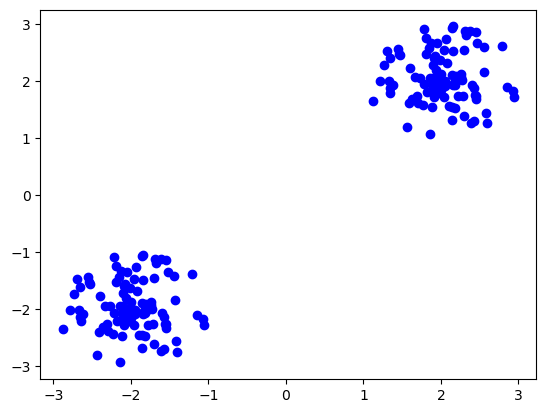

In [5]:
%%px --target 0
import matplotlib.pyplot as plt
plt.plot(data_np[:,0], data_np[:,1], 'bo')

Now we perform the clustering analysis with kmeans. We chose 'kmeans++' as an intelligent way of sampling the
initial centroids.

In [6]:
%%px
kmeans = ht.cluster.KMeans(n_clusters=2, init="kmeans++")
labels = kmeans.fit_predict(data).squeeze()
centroids = kmeans.cluster_centers_

# Select points assigned to clusters c1 and c2
c1 = data[ht.where(labels == 0), :]
c2 = data[ht.where(labels == 1), :]
# After slicing, the arrays are no longer distributed evenly among the processes; we might need to balance the load
c1.balance_() #in-place operation
c2.balance_()

print(f"Number of points assigned to c1: {c1.shape[0]} \n"
        f"Number of points assigned to c2: {c2.shape[0]} \n"
        f"Centroids = {centroids}")


[stdout:3] Number of points assigned to c1: 100 
Number of points assigned to c2: 100 
Centroids = DNDarray([[ 2.0065,  2.0425],
          [-1.9935, -1.9575]], dtype=ht.float32, device=cpu:0, split=None)


[stdout:2] Number of points assigned to c1: 100 
Number of points assigned to c2: 100 
Centroids = DNDarray([[ 2.0065,  2.0425],
          [-1.9935, -1.9575]], dtype=ht.float32, device=cpu:0, split=None)


[stdout:0] Number of points assigned to c1: 100 
Number of points assigned to c2: 100 
Centroids = DNDarray([[ 2.0065,  2.0425],
          [-1.9935, -1.9575]], dtype=ht.float32, device=cpu:0, split=None)


[stdout:1] Number of points assigned to c1: 100 
Number of points assigned to c2: 100 
Centroids = DNDarray([[ 2.0065,  2.0425],
          [-1.9935, -1.9575]], dtype=ht.float32, device=cpu:0, split=None)


Let's plot the assigned clusters and the respective centroids:


In [7]:
%%px
# just for plotting: collect all the data on each process and extract the numpy arrays. This will copy data to CPU if necessary.
c1_np = c1.numpy()
c2_np = c2.numpy()

[output:0]

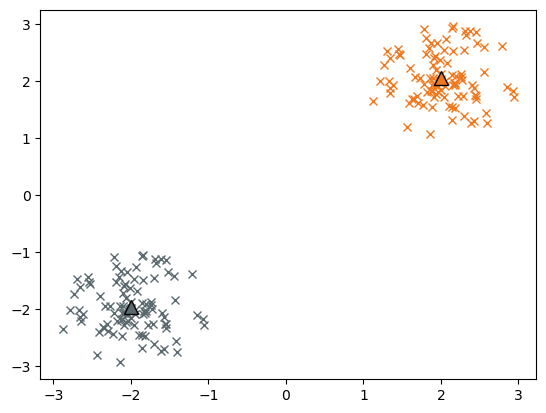

In [8]:
%%px --target 0
# plotting on 1 process only
plt.plot(c1_np[:,0], c1_np[:,1], 'x', color='#f0781e')
plt.plot(c2_np[:,0], c2_np[:,1], 'x', color='#5a696e')
plt.plot(centroids[0,0],centroids[0,1], '^', markersize=10, markeredgecolor='black', color='#f0781e' )
plt.plot(centroids[1,0],centroids[1,1], '^', markersize=10, markeredgecolor='black',color='#5a696e')
plt.show()

We can also cluster the data with kmedians. The respective advanced initial centroid sampling is called 'kmedians++'.

In [9]:
%%px
kmedians = ht.cluster.KMedians(n_clusters=2, init="kmedians++")
labels = kmedians.fit_predict(data).squeeze()
centroids = kmedians.cluster_centers_

# Select points assigned to clusters c1 and c2
c1 = data[ht.where(labels == 0), :]
c2 = data[ht.where(labels == 1), :]
# After slicing, the arrays are not distributed equally among the processes anymore; we need to balance
c1.balance_()
c2.balance_()

print(f"Number of points assigned to c1: {c1.shape[0]} \n"
        f"Number of points assigned to c2: {c2.shape[0]} \n"
        f"Centroids = {centroids}")

[stdout:3] Number of points assigned to c1: 100 
Number of points assigned to c2: 100 
Centroids = DNDarray([[-2.0081, -2.0299],
          [ 1.9919,  1.9701]], dtype=ht.float32, device=cpu:0, split=None)


[stdout:2] Number of points assigned to c1: 100 
Number of points assigned to c2: 100 
Centroids = DNDarray([[-2.0081, -2.0299],
          [ 1.9919,  1.9701]], dtype=ht.float32, device=cpu:0, split=None)


[stdout:0] Number of points assigned to c1: 100 
Number of points assigned to c2: 100 
Centroids = DNDarray([[-2.0081, -2.0299],
          [ 1.9919,  1.9701]], dtype=ht.float32, device=cpu:0, split=None)


[stdout:1] Number of points assigned to c1: 100 
Number of points assigned to c2: 100 
Centroids = DNDarray([[-2.0081, -2.0299],
          [ 1.9919,  1.9701]], dtype=ht.float32, device=cpu:0, split=None)


Plotting the assigned clusters and the respective centroids:


In [10]:
%%px
c1_np = c1.numpy()
c2_np = c2.numpy()

[output:0]

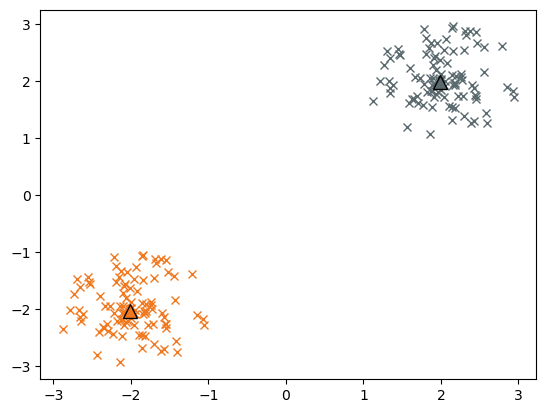

In [12]:
%%px --target 0
plt.plot(c1_np[:,0], c1_np[:,1], 'x', color='#f0781e')
plt.plot(c2_np[:,0], c2_np[:,1], 'x', color='#5a696e')
plt.plot(centroids[0,0],centroids[0,1], '^', markersize=10, markeredgecolor='black', color='#f0781e' )
plt.plot(centroids[1,0],centroids[1,1], '^', markersize=10, markeredgecolor='black',color='#5a696e')
plt.show()

The Iris Dataset
------------------------------
The _iris_ dataset is a well known example for clustering analysis. It contains 4 measured features for samples from
three different types of iris flowers. A subset of 150 samples is included in formats h5, csv and netcdf in the [Heat repository under 'heat/heat/datasets'](https://github.com/helmholtz-analytics/heat/tree/main/heat/datasets), and can be loaded in a distributed manner with Heat's parallel dataloader.

**NOTE: you might have to change the path to the dataset in the following cell.**

In [19]:
%%px
iris = ht.load("./heat/datasets/iris.csv", sep=";", split=0)

Feel free to try out the other [loading options](https://heat.readthedocs.io/en/stable/autoapi/heat/core/io/index.html#heat.core.io.load) as well.

Fitting the dataset with `kmeans`:

In [20]:
%%px
k = 3
kmeans = ht.cluster.KMeans(n_clusters=k, init="kmeans++")
kmeans.fit(iris)


Out[2:20]: 
KMeans({
    "n_clusters": 3,
    "init": "probability_based",
    "max_iter": 300,
    "tol": 0.0001,
    "random_state": null
})

Out[3:20]: 
KMeans({
    "n_clusters": 3,
    "init": "probability_based",
    "max_iter": 300,
    "tol": 0.0001,
    "random_state": null
})

Out[1:20]: 
KMeans({
    "n_clusters": 3,
    "init": "probability_based",
    "max_iter": 300,
    "tol": 0.0001,
    "random_state": null
})

Out[0:26]: 
KMeans({
    "n_clusters": 3,
    "init": "probability_based",
    "max_iter": 300,
    "tol": 0.0001,
    "random_state": null
})

Let's see what the results are. In theory, there are 50 samples of each of the 3 iris types: setosa, versicolor and virginica. We will plot the results in a 3D scatter plot, coloring the samples according to the assigned cluster.

In [21]:
%%px
labels = kmeans.predict(iris).squeeze()

# Select points assigned to clusters c1, c2 and c3
c1 = iris[ht.where(labels == 0), :]
c2 = iris[ht.where(labels == 1), :]
c3 = iris[ht.where(labels == 2), :]
# After slicing, the arrays are not distributed equally among the processes anymore; we need to balance
#TODO is balancing really necessary?
c1.balance_()
c2.balance_()
c3.balance_()

print(f"Number of points assigned to c1: {c1.shape[0]} \n"
        f"Number of points assigned to c2: {c2.shape[0]} \n"
        f"Number of points assigned to c3: {c3.shape[0]}")

[stdout:3] Number of points assigned to c1: 50 
Number of points assigned to c2: 38 
Number of points assigned to c3: 62


[stdout:0] Number of points assigned to c1: 50 
Number of points assigned to c2: 38 
Number of points assigned to c3: 62


[stdout:1] Number of points assigned to c1: 50 
Number of points assigned to c2: 38 
Number of points assigned to c3: 62


[stdout:2] Number of points assigned to c1: 50 
Number of points assigned to c2: 38 
Number of points assigned to c3: 62


In [22]:
# compare Heat results with sklearn
from sklearn.cluster import KMeans
import sklearn.datasets
k = 3
iris_sk = sklearn.datasets.load_iris().data
kmeans_sk = KMeans(n_clusters=k, init="k-means++").fit(iris_sk)
labels_sk = kmeans_sk.predict(iris_sk)

c1_sk = iris_sk[labels_sk == 0, :]
c2_sk = iris_sk[labels_sk == 1, :]
c3_sk = iris_sk[labels_sk == 2, :]
print(f"Number of points assigned to c1: {c1_sk.shape[0]} \n"
        f"Number of points assigned to c2: {c2_sk.shape[0]} \n"
        f"Number of points assigned to c3: {c3_sk.shape[0]}")

Number of points assigned to c1: 50 
Number of points assigned to c2: 39 
Number of points assigned to c3: 61
